# Basketball Noodling

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import re
from pprint import pprint

import requests
from pathlib import Path

## Get a few box scores

In [16]:
data_path = Path("/Users/rory/data/ncaa_stats/box_score")

cu_game_ids = [
    5736833,
    5731718,
    5736837,
]

In [ ]:
def box_score_html(game_id):
    """Downloads and saves a box score HTML page from NCAA Stats

    Parameters
    ----------
    game_id : int
        NCAA game ID

    Returns
    -------
        str
            The content of the downloaded HTML file, or None if an error occurred.
    """
    html_path = data_path / f"{game_id}.html"
    if html_path.exists():
        print("Got this one", game_id)
        return html_path.read_text()

    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    url = "https://stats.ncaa.org/contests/5731718/box_score"
    r = requests.get(url, headers=headers)

    if not r.ok:
        print("Problem", r.text)

    html_path.write_bytes(r.content)
    return r.text

In [15]:
for game_id in cu_game_ids:
    download(game_id)

Got this one 5736833
Got this one 5731718
Got this one 5736837


In [20]:
html_content = box_score_html(5736837)

Got this one 5736837


In [24]:
soup = BeautifulSoup(html_content)

# Updated regex pattern for the specific `addShot` format you provided
shot_data_pattern = re.compile(
    r"addShot\(\s*([\d.]+),\s*([\d.]+),\s*(\d+),\s*(true|false),\s*(\d+),\s*'([^']+)',\s*'([^']+)',\s*(true|false)\s*\);"
)

shot_data = []

for script in soup.find_all("script"):
    if script.string and shot_data_pattern.search(script.string):
        for match in shot_data_pattern.findall(script.string):
            # Map matched groups to relevant fields
            shot = {
                "x": float(match[0]),  # X-coordinate
                "y": float(match[1]),  # Y-coordinate
                "team_id": int(match[2]),  # Team ID
                "made": match[3] == "true",  # Shot success (True if 'made')
                "player_id": int(match[4]),  # Player ID
                "description": match[5],  # Shot description
                "meta_info": match[6],  # Additional metadata
                "flag": match[7] == "true",  # Extra boolean flag, if needed
            }
            shot_data.append(shot)


# Extract teams and players from the dropdowns
teams = {}
for option in soup.select("#team_select option"):
    if option.get("value").isdigit():
        teams[int(option["value"])] = option.text.strip()

players = {}
for optgroup in soup.select("#player_select optgroup"):
    team = optgroup.get("label")
    players[team] = {
        int(option["value"]): option.text.strip()
        for option in optgroup.find_all("option")
    }

# Print results
# print("Shot Data:", shot_data)
print("Teams:", teams)
print("Players by Team:")
pprint(players)

Teams: {157: 'Colorado', 811: 'Wyoming'}
Players by Team:
{'Colorado': {775989920: 'Nyamer Diew',
              775989921: 'Lior Garzon',
              775989922: 'Johanna Teder',
              775989923: 'Sara-Rose Smith',
              775989924: 'Kindyll Wetta',
              775989925: 'Jade Masogayo',
              775989926: 'Kennedy Sanders',
              775989927: 'Ayianna Johnson',
              775989928: 'Tabitha Betson'},
 'Wyoming': {775989908: 'Ola Ustowska',
             775989909: 'Malene Pedersen',
             775989910: 'Emily Mellema',
             775989911: 'Tess Barnes',
             775989912: 'Allyson Fertig',
             775989913: 'Payton Muma',
             775989914: 'Mikyn Hamlin',
             775989915: 'Kati Ollilainen',
             775989916: 'Madi Symons',
             775989917: 'Logann Alvar'}}


In [23]:
shot_data

[{'x': 91.0,
  'y': 43.0,
  'team_id': 157,
  'made': False,
  'player_id': 2680563039,
  'description': '1st 09:39:00 : missed by Nyamer Diew(Colorado) 0-0',
  'meta_info': 'period_1 player_775989920 team_157',
  'flag': False},
 {'x': 11.0,
  'y': 54.0,
  'team_id': 811,
  'made': False,
  'player_id': 2680563041,
  'description': '1st 09:26:00 : missed by Emily Mellema(Wyoming) 0-0',
  'meta_info': 'period_1 player_775989910 team_811',
  'flag': False},
 {'x': 90.0,
  'y': 52.0,
  'team_id': 157,
  'made': True,
  'player_id': 2680563045,
  'description': '1st 09:08:00 : made by Tabitha Betson(Colorado) 2-0',
  'meta_info': 'period_1 player_775989928 team_157',
  'flag': False},
 {'x': 24.0,
  'y': 43.0,
  'team_id': 811,
  'made': False,
  'player_id': 2680563046,
  'description': '1st 08:42:00 : missed by Emily Mellema(Wyoming) 2-0',
  'meta_info': 'period_1 player_775989910 team_811',
  'flag': False},
 {'x': 15.0,
  'y': 94.0,
  'team_id': 811,
  'made': True,
  'player_id': 268

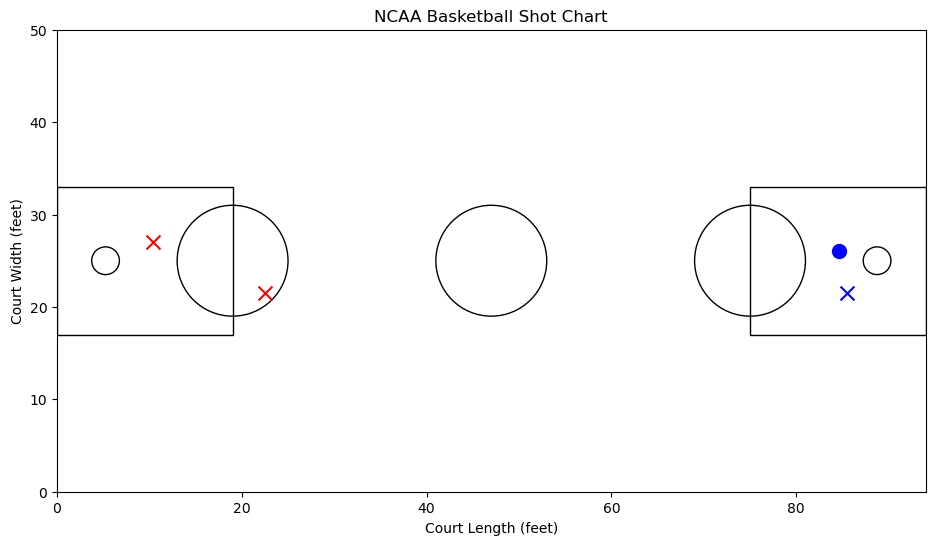

In [26]:
# Sample shot data
shot_data = [
    {
        "x": 91.0,
        "y": 43.0,
        "team_id": 157,
        "made": False,
        "player_id": 2680563039,
        "description": "1st 09:39:00 : missed by Nyamer Diew(Colorado) 0-0",
        "meta_info": "period_1 player_775989920 team_157",
        "flag": False,
    },
    {
        "x": 11.0,
        "y": 54.0,
        "team_id": 811,
        "made": False,
        "player_id": 2680563041,
        "description": "1st 09:26:00 : missed by Emily Mellema(Wyoming) 0-0",
        "meta_info": "period_1 player_775989910 team_811",
        "flag": False,
    },
    {
        "x": 90.0,
        "y": 52.0,
        "team_id": 157,
        "made": True,
        "player_id": 2680563045,
        "description": "1st 09:08:00 : made by Tabitha Betson(Colorado) 2-0",
        "meta_info": "period_1 player_775989928 team_157",
        "flag": False,
    },
    {
        "x": 24.0,
        "y": 43.0,
        "team_id": 811,
        "made": False,
        "player_id": 2680563046,
        "description": "1st 08:42:00 : missed by Emily Mellema(Wyoming) 2-0",
        "meta_info": "period_1 player_775989910 team_811",
        "flag": False,
    },
]


# Function to draw an NCAA Basketball Court
def draw_court(ax=None):
    if ax is None:
        ax = plt.gca()

    # Court dimensions
    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)

    # Paint areas
    ax.add_patch(patches.Rectangle((0, 17), 19, 16, fill=False, color="black"))
    ax.add_patch(patches.Rectangle((75, 17), 19, 16, fill=False, color="black"))

    # Hoops
    ax.add_patch(patches.Circle((5.25, 25), 1.5, fill=False, color="black"))
    ax.add_patch(patches.Circle((88.75, 25), 1.5, fill=False, color="black"))

    # Free throw circles
    ax.add_patch(patches.Circle((19, 25), 6, fill=False, color="black"))
    ax.add_patch(patches.Circle((75, 25), 6, fill=False, color="black"))

    # Center circle
    ax.add_patch(patches.Circle((47, 25), 6, fill=False, color="black"))


# Plot the court
fig, ax = plt.subplots(figsize=(12, 6))
draw_court(ax)

for shot in shot_data:
    color = "blue" if shot["team_id"] == 157 else "red"  # Different colors for teams
    marker = (
        "o" if shot["made"] else "x"
    )  # Made shots are circles, missed shots are crosses
    ax.scatter(
        shot["x"] * 94 / 100, shot["y"] * 50 / 100, color=color, marker=marker, s=100
    )

# Add title and set axis properties
plt.title("NCAA Basketball Shot Chart")
plt.xlabel("Court Length (feet)")
plt.ylabel("Court Width (feet)")
# plt.legend(loc='upper right')
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

/var/folders/jg/pzxyc9d57qs14dktxjrz_wnr0000gn/T/ipykernel_10814/3713428392.py:60: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(shot["x"], shot["y"], color=color, marker=marker, s=100, edgecolors="black")


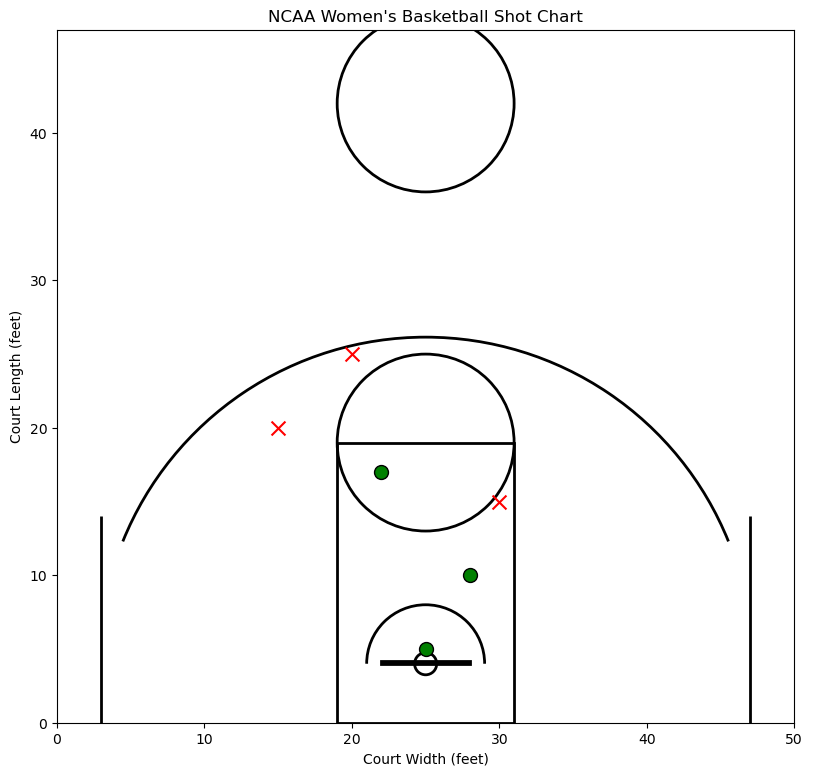

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Sample shot data (for context in case you'd like to plot shots too)
shot_data = [
    {"x": 25, "y": 5, "made": True},  # Layup
    {"x": 15, "y": 20, "made": False},  # Near free throw area
    {"x": 28, "y": 10, "made": True},  # Mid-range make
    {"x": 20, "y": 25, "made": False},  # Top of the key
    {"x": 22, "y": 17, "made": True},  # Close-range shot
    {"x": 30, "y": 15, "made": False},  # Missed three-pointer
]


# Function to draw an NCAA Women's Basketball half-court with a 3-point line
def draw_ncaa_womens_court(ax=None, color="black", lw=2):
    if ax is None:
        ax = plt.gca()

    # Set court dimensions
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 47)

    # Hoop
    hoop = patches.Circle((25, 4), radius=0.75, linewidth=lw, color=color, fill=False)

    # Backboard
    backboard = patches.Rectangle((22, 4), 6, 0.2, linewidth=lw, color=color)

    # Paint (key) area
    paint = patches.Rectangle((19, 0), 12, 19, linewidth=lw, color=color, fill=False)
    free_throw_circle = patches.Circle(
        (25, 19), 6, linewidth=lw, color=color, fill=False
    )

    # Restricted area
    restricted_area = patches.Arc(
        (25, 4), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color
    )

    # 3-point line (arc + straight lines)
    three_point_arc = patches.Arc(
        (25, 4), 44.3, 44.3, theta1=22, theta2=158, linewidth=lw, color=color
    )
    corner_three_a = patches.Rectangle((3, 0), 0, 14, linewidth=lw, color=color)
    corner_three_b = patches.Rectangle((47, 0), 0, 14, linewidth=lw, color=color)

    # Center court circle
    center_circle = patches.Circle((25, 42), 6, linewidth=lw, color=color, fill=False)

    # Add all elements to the court
    court_elements = [
        hoop,
        backboard,
        paint,
        free_throw_circle,
        restricted_area,
        three_point_arc,
        corner_three_a,
        corner_three_b,
        center_circle,
    ]
    for element in court_elements:
        ax.add_patch(element)

    return ax


# Plotting the NCAA Women's Basketball court and shots
fig, ax = plt.subplots(figsize=(10, 9))
draw_ncaa_womens_court(ax)

# Plot each shot on the court
for shot in shot_data:
    color = "green" if shot["made"] else "red"  # Green for made, red for missed
    marker = "o" if shot["made"] else "x"  # Circle for made, cross for missed
    ax.scatter(
        shot["x"], shot["y"], color=color, marker=marker, s=100, edgecolors="black"
    )

# Set axis properties and add title
plt.title("NCAA Women's Basketball Shot Chart")
plt.xlabel("Court Width (feet)")
plt.ylabel("Court Length (feet)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

In [ ]:
# Function to draw a full NCAA basketball court
def draw_full_ncaa_court(ax=None, color="black", lw=2):
    if ax is None:
        ax = plt.gca()

    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)

    hoop_left = patches.Circle(
        (5.25, 25), radius=0.75, linewidth=lw, color=color, fill=False
    )
    hoop_right = patches.Circle(
        (88.75, 25), radius=0.75, linewidth=lw, color=color, fill=False
    )

    # Define both backboards
    backboard_left = patches.Rectangle((4, 22), 0.2, 6, linewidth=lw, color=color)
    backboard_right = patches.Rectangle((89.8, 22), 0.2, 6, linewidth=lw, color=color)

    # Define both paint areas
    paint_left = patches.Rectangle(
        (0, 19), 19, 12, linewidth=lw, color=color, fill=False
    )
    paint_right = patches.Rectangle(
        (75, 19), 19, 12, linewidth=lw, color=color, fill=False
    )

    # Define both free throw circles
    free_throw_circle_left = patches.Circle(
        (19, 25), 6, linewidth=lw, color=color, fill=False
    )
    free_throw_circle_right = patches.Circle(
        (75, 25), 6, linewidth=lw, color=color, fill=False
    )

    # Define restricted areas
    restricted_left = patches.Arc(
        (5.25, 25), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color
    )
    restricted_right = patches.Arc(
        (88.75, 25), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color
    )

    # Define three-point arcs and lines
    three_point_arc_left = patches.Arc(
        (5.25, 25), 44.3, 44.3, theta1=-68, theta2=68, linewidth=lw, color=color
    )
    three_point_arc_right = patches.Arc(
        (88.75, 25), 44.3, 44.3, theta1=112, theta2=248, linewidth=lw, color=color
    )
    corner_three_left = patches.Rectangle((0, 19), 3, 12, linewidth=lw, color=color)
    corner_three_right = patches.Rectangle((91, 19), 3, 12, linewidth=lw, color=color)

    # Define center court circle
    center_circle = patches.Circle((47, 25), 6, linewidth=lw, color=color, fill=False)

    # Define half-court line
    half_court_line = patches.Rectangle((47, 0), 0.2, 50, linewidth=lw, color=color)

    # Add all elements to the court
    court_elements = [
        hoop_left,
        hoop_right,
        backboard_left,
        backboard_right,
        paint_left,
        paint_right,
        free_throw_circle_left,
        free_throw_circle_right,
        # restricted_left,
        # restricted_right,
        three_point_arc_left,
        three_point_arc_right,
        corner_three_left,
        corner_three_right,
        center_circle,
        half_court_line,
    ]
    for element in court_elements:
        ax.add_patch(element)

    return ax

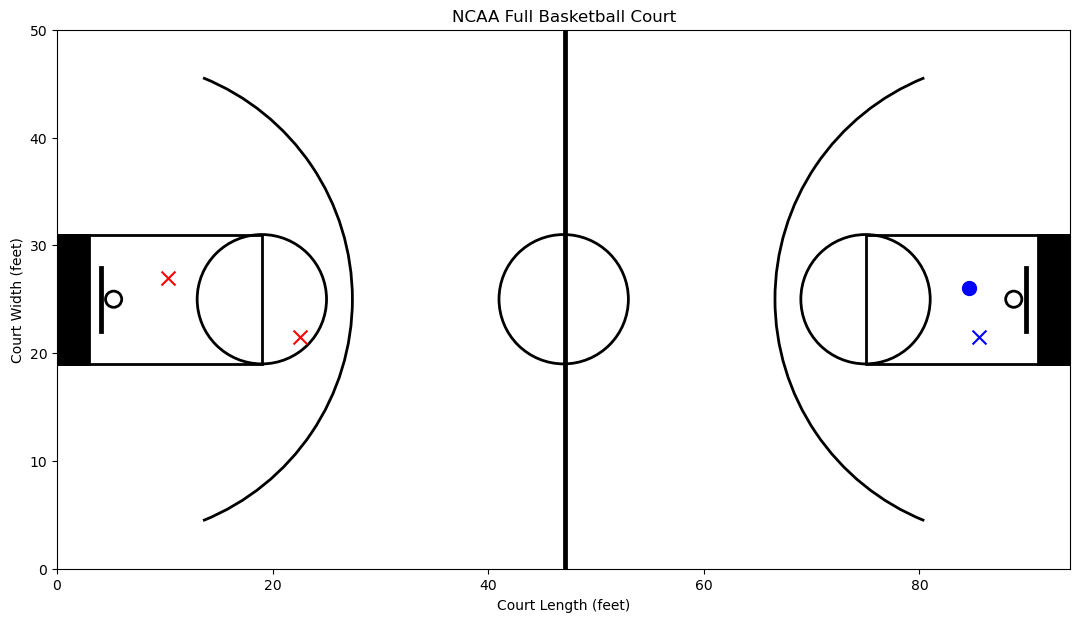

In [33]:
# Plot the full NCAA basketball court
fig, ax = plt.subplots(figsize=(14, 7))
draw_full_ncaa_court(ax)

shot_data = [
    {
        "x": 91.0,
        "y": 43.0,
        "team_id": 157,
        "made": False,
        "player_id": 2680563039,
        "description": "1st 09:39:00 : missed by Nyamer Diew(Colorado) 0-0",
        "meta_info": "period_1 player_775989920 team_157",
        "flag": False,
    },
    {
        "x": 11.0,
        "y": 54.0,
        "team_id": 811,
        "made": False,
        "player_id": 2680563041,
        "description": "1st 09:26:00 : missed by Emily Mellema(Wyoming) 0-0",
        "meta_info": "period_1 player_775989910 team_811",
        "flag": False,
    },
    {
        "x": 90.0,
        "y": 52.0,
        "team_id": 157,
        "made": True,
        "player_id": 2680563045,
        "description": "1st 09:08:00 : made by Tabitha Betson(Colorado) 2-0",
        "meta_info": "period_1 player_775989928 team_157",
        "flag": False,
    },
    {
        "x": 24.0,
        "y": 43.0,
        "team_id": 811,
        "made": False,
        "player_id": 2680563046,
        "description": "1st 08:42:00 : missed by Emily Mellema(Wyoming) 2-0",
        "meta_info": "period_1 player_775989910 team_811",
        "flag": False,
    },
]


for shot in shot_data:
    color = "blue" if shot["team_id"] == 157 else "red"  # Different colors for teams
    marker = (
        "o" if shot["made"] else "x"
    )  # Made shots are circles, missed shots are crosses
    ax.scatter(
        shot["x"] * 94 / 100, shot["y"] * 50 / 100, color=color, marker=marker, s=100
    )


# Set axis properties
plt.title("NCAA Full Basketball Court")
plt.xlabel("Court Length (feet)")
plt.ylabel("Court Width (feet)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()